# Chess Dual Training Diagnostics - Performance Analysis

This notebook analyzes the chess dual training performance for both white and black players.
Tracks game outcomes, player metrics, and training convergence.

In [757]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from matplotlib.animation import FuncAnimation

# Chess piece types
PIECE_TYPES = ["PAWN", "KNIGHT", "BISHOP", "ROOK", "QUEEN", "KING"]

# Chess action encoding: 64x64 from-to moves = 4096 actions
CHESS_ACTIONS = 4096

def decode_chess_action(action_idx):
    """Decode action index to from/to squares."""
    from_square = action_idx // 64
    to_square = action_idx % 64
    
    from_row, from_col = from_square // 8, from_square % 8
    to_row, to_col = to_square // 8, to_square % 8
    
    return {
        'from_square': from_square,
        'to_square': to_square,
        'from_pos': (from_row, from_col),
        'to_pos': (to_row, to_col)
    }

# Folder containing chess training log files
LOG_DIR = "./logs_w['rook', 'bishop', 'king']_b['pawn', 'knight', 'king']_dual"   # Change this to your chess log directory
LOG_DIR = "./logs_wpawn_bpawn_dual"   # Change this to your chess log directory --- IGNORE ---
LOG_DIR="./logs_w['queen', 'king']_b['knight', 'king']_dual"
LOG_DIR="logs_w['rook', 'queen', 'king']_b['knight', 'bishop', 'pawn', 'king']_dual"
LOG_DIR="logs_w['rook', 'pawn', 'knight', 'bishop', 'queen', 'king']_b['rook', 'pawn', 'knight', 'bishop', 'queen', 'king']_dual"
# Regex to match chess episode filenames
pattern = re.compile(r"episode_(\d+)_(\d+)\.json$")

rows = []

if os.path.exists(LOG_DIR):
    for fname in os.listdir(LOG_DIR):
        match = pattern.match(fname)
        if not match:
            continue

        episode_num = int(match.group(1))
        timestamp = int(match.group(2))

        full_path = os.path.join(LOG_DIR, fname)

        try:
            with open(full_path, "r") as f:
                data = json.load(f)
            
            # Extract episode data
            episode_rewards = data.get('episode_rewards', {})
            game_stats = data.get('game_stats', {})
            white_metrics = data.get('white_metrics', {})
            black_metrics = data.get('black_metrics', {})
            game_length_analysis = data.get('game_length_analysis', {})
            row = {
                "filename": fname,
                "episode": data.get("episode", episode_num),
                "timestamp": data.get("timestamp", timestamp),
                
                # Game outcomes
                "white_wins": game_stats.get("white_wins", 0),
                "black_wins": game_stats.get("black_wins", 0),
                "draws": game_stats.get("draws", 0),
                "stalemate_white": game_stats.get("stalemate_white", 0),
                "stalemate_black": game_stats.get("stalemate_black", 0),
                "total_games": game_stats.get("total_games", 0),
                "white_win_rate": game_stats.get("white_win_rate", 0.0),
                "black_win_rate": game_stats.get("black_win_rate", 0.0),
                "draws_rate": game_stats.get("draws", 0.0)/game_stats.get("total_games", 1),
                "stalemate_white_rate": game_stats.get("stalemate_white", 0)/game_stats.get("total_games", 1),
                "stalemate_black_rate": game_stats.get("stalemate_black", 0)/game_stats.get("total_games", 1),
                # Episode rewards
                "white_episode_reward": episode_rewards.get("white_reward", 0.0),
                "black_episode_reward": episode_rewards.get("black_reward", 0.0),
                "total_episode_reward": episode_rewards.get("total_reward", 0.0),
                
                # Game length analysis
                "avg_white_win_length": game_length_analysis.get("avg_white_win_length", 0.0),
                "avg_black_win_length": game_length_analysis.get("avg_black_win_length", 0.0),
                "avg_recent_game_length": game_length_analysis.get("avg_recent_game_length", 0.0),
                
                # White player metrics
                "white_policy_loss": white_metrics.get("policy_loss"),
                "white_value_loss": white_metrics.get("value_loss"),
                "white_entropy": white_metrics.get("entropy"),
                "white_approx_kl": white_metrics.get("approx_kl"),
                "white_explained_variance": white_metrics.get("explained_variance"),
                "white_n_updates": white_metrics.get("n_updates", 0),
                "white_advantage_mean": white_metrics.get("advantage_mean"),
                "white_advantage_std": white_metrics.get("advantage_std"),
                "white_return_mean": white_metrics.get("return_mean"),
                "white_return_std": white_metrics.get("return_std"),
                "white_value_mean": white_metrics.get("value_mean"),
                "white_value_std": white_metrics.get("value_std"),
                "white_recent_avg_return": white_metrics.get("recent_avg_return", 0.0),
                "white_total_reward": white_metrics.get("total_reward", 0.0),
                
                # Black player metrics
                "black_policy_loss": black_metrics.get("policy_loss"),
                "black_value_loss": black_metrics.get("value_loss"),
                "black_entropy": black_metrics.get("entropy"),
                "black_approx_kl": black_metrics.get("approx_kl"),
                "black_explained_variance": black_metrics.get("explained_variance"),
                "black_n_updates": black_metrics.get("n_updates", 0),
                "black_advantage_mean": black_metrics.get("advantage_mean"),
                "black_advantage_std": black_metrics.get("advantage_std"),
                "black_return_mean": black_metrics.get("return_mean"),
                "black_return_std": black_metrics.get("return_std"),
                "black_value_mean": black_metrics.get("value_mean"),
                "black_value_std": black_metrics.get("value_std"),
                "black_recent_avg_return": black_metrics.get("recent_avg_return", 0.0),
                "black_total_reward": black_metrics.get("total_reward", 0.0),
            }

            rows.append(row)
            
        except (json.JSONDecodeError, KeyError) as e:
            print(f"Error parsing {fname}: {e}")
            continue

    # Create DataFrame
    df = pd.DataFrame(rows)
    
    if len(df) > 0:
        print(f"Successfully parsed {len(df)} chess training episodes")
        print(df.head())
    else:
        print(f"No valid chess logs found in {LOG_DIR}")
        print("Make sure you have chess training logs with the correct format.")
else:
    print(f"Directory {LOG_DIR} not found!")
    print("Please update LOG_DIR to point to your chess training logs directory.")

Successfully parsed 181 chess training episodes
                       filename  episode   timestamp  white_wins  black_wins  \
0  episode_1000_1765133232.json     1000  1765133232       38645       36421   
1   episode_100_1765086922.json      100  1765086922        3008        2917   
2  episode_1010_1765133709.json     1010  1765133709       39049       36842   
3  episode_1020_1765134172.json     1020  1765134172       39461       37254   
4  episode_1030_1765134669.json     1030  1765134669       39859       37670   

   draws  stalemate_white  stalemate_black  total_games  white_win_rate  ...  \
0  24933                0                0        99999        0.386454  ...   
1   4074                0                0         9999        0.300830  ...   
2  25108                0                0       100999        0.386628  ...   
3  25284                0                0       101999        0.386876  ...   
4  25470                0                0       102999        0.386984

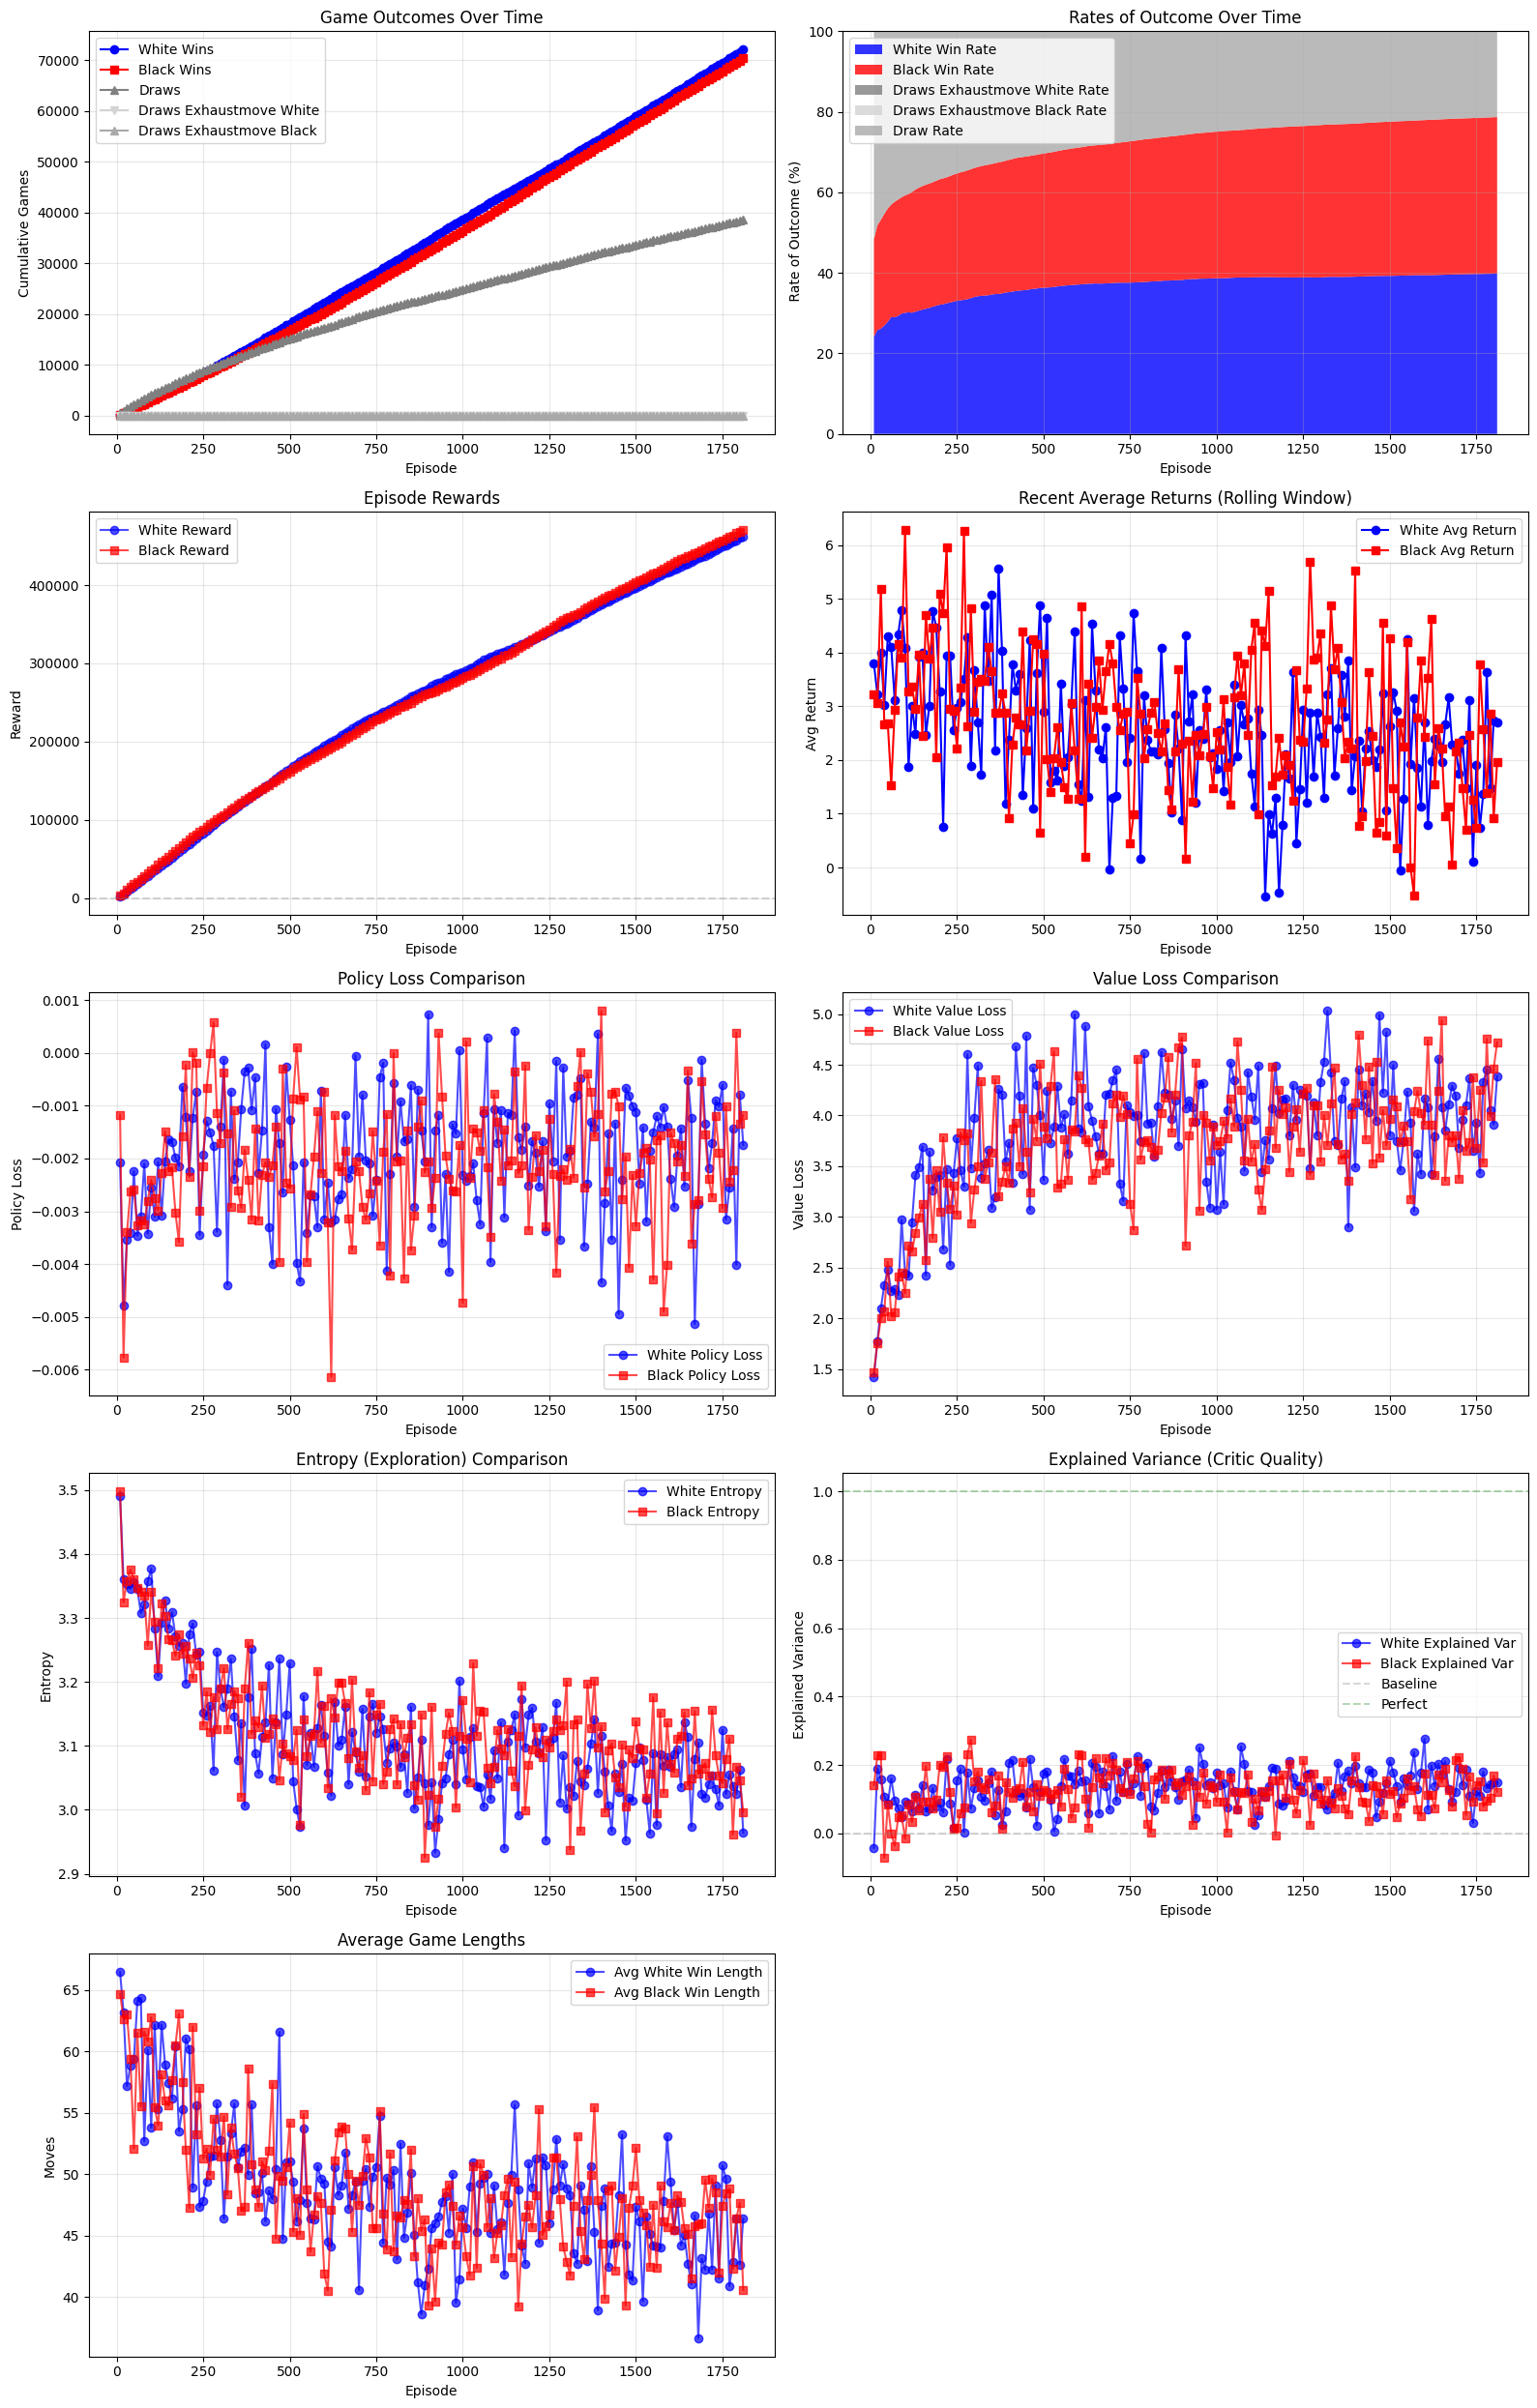


CHESS TRAINING SUMMARY
Total Episodes Analyzed: 181
Total Games Played: 180999

Final Win Rates:
  White: 39.8% (72075 wins)
  Black: 38.9% (70351 wins)
  Draws: 21.3% (38573 draws)

Game Length Analysis:
  Avg White Win Length: 46.4 moves
  Avg Black Win Length: 40.6 moves
  Avg Recent Game Length: 46.1 moves

Performance Trends:
  White avg return trend: -0.000895 per episode
  Black avg return trend: -0.000786 per episode

Latest Metrics:
  White - Policy Loss: -0.0017, Value Loss: 4.3880
  Black - Policy Loss: -0.0012, Value Loss: 4.7232
  White Explained Var: 0.1493
  Black Explained Var: 0.1225


In [758]:
if len(df) > 0:
    # Comprehensive chess training diagnostic plot
    fig, axes = plt.subplots(5, 2, figsize=(16, 25))
    df_sorted = df.sort_values("episode").reset_index(drop=True)

    # 1. Game Outcomes
    axes[0, 0].plot(df_sorted["episode"], df_sorted["white_wins"], marker="o", color="blue", label="White Wins")
    axes[0, 0].plot(df_sorted["episode"], df_sorted["black_wins"], marker="s", color="red", label="Black Wins")
    axes[0, 0].plot(df_sorted["episode"], df_sorted["draws"], marker="^", color="gray", label="Draws")
    axes[0, 0].plot(df_sorted["episode"], df_sorted["stalemate_white"], marker="v", color="lightgray", label="Draws Exhaustmove White")
    axes[0, 0].plot(df_sorted["episode"], df_sorted["stalemate_black"], marker="^", color="darkgray", label="Draws Exhaustmove Black")
    axes[0, 0].set_title("Game Outcomes Over Time")
    axes[0, 0].set_xlabel("Episode")
    axes[0, 0].set_ylabel("Cumulative Games")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Win Rates (Stacked Area Chart)
    axes[0, 1].stackplot(
        df_sorted["episode"],
        df_sorted["white_win_rate"] * 100,
        df_sorted["black_win_rate"] * 100,
        df_sorted["stalemate_white_rate"] * 100,
        df_sorted["stalemate_black_rate"] * 100,
        df_sorted["draws_rate"] * 100,

        labels=[
            "White Win Rate",
            "Black Win Rate",
            "Draws Exhaustmove White Rate",
            "Draws Exhaustmove Black Rate",
            "Draw Rate"

        ],
        colors=["blue", "red", "gray", "lightgray", "darkgray"],
        alpha=0.8
    )

    # axes[0, 1].axhline(y=50, color='black', linestyle='--', alpha=0.5, label="Equal (50%)")
    axes[0, 1].set_title("Rates of Outcome Over Time")
    axes[0, 1].set_xlabel("Episode")
    axes[0, 1].set_ylabel(" Rate of Outcome (%)")
    axes[0, 1].legend(loc="upper left")
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim(0, 100)


    # 3. Episode Rewards
    axes[1, 0].plot(df_sorted["episode"], df_sorted["white_total_reward"], marker="o", 
                   color="blue", alpha=0.7, label="White Reward")
    axes[1, 0].plot(df_sorted["episode"], df_sorted["black_total_reward"], marker="s", 
                   color="red", alpha=0.7, label="Black Reward")
    axes[1, 0].axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    axes[1, 0].set_title("Episode Rewards")
    axes[1, 0].set_xlabel("Episode")
    axes[1, 0].set_ylabel("Reward")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Recent Average Returns
    axes[1, 1].plot(df_sorted["episode"], df_sorted["white_recent_avg_return"], marker="o", 
                   color="blue", label="White Avg Return")
    axes[1, 1].plot(df_sorted["episode"], df_sorted["black_recent_avg_return"], marker="s", 
                   color="red", label="Black Avg Return")
    axes[1, 1].set_title("Recent Average Returns (Rolling Window)")
    axes[1, 1].set_xlabel("Episode")
    axes[1, 1].set_ylabel("Avg Return")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # 5. Policy Loss Comparison
    axes[2, 0].plot(df_sorted["episode"], df_sorted["white_policy_loss"], marker="o", 
                   color="blue", alpha=0.7, label="White Policy Loss")
    axes[2, 0].plot(df_sorted["episode"], df_sorted["black_policy_loss"], marker="s", 
                   color="red", alpha=0.7, label="Black Policy Loss")
    axes[2, 0].set_title("Policy Loss Comparison")
    axes[2, 0].set_xlabel("Episode")
    axes[2, 0].set_ylabel("Policy Loss")
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)

    # 6. Value Loss Comparison  
    axes[2, 1].plot(df_sorted["episode"], df_sorted["white_value_loss"], marker="o", 
                   color="blue", alpha=0.7, label="White Value Loss")
    axes[2, 1].plot(df_sorted["episode"], df_sorted["black_value_loss"], marker="s", 
                   color="red", alpha=0.7, label="Black Value Loss")
    axes[2, 1].set_title("Value Loss Comparison")
    axes[2, 1].set_xlabel("Episode")
    axes[2, 1].set_ylabel("Value Loss")
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3)

    # 7. Entropy (Exploration) Comparison
    axes[3, 0].plot(df_sorted["episode"], df_sorted["white_entropy"], marker="o", 
                   color="blue", alpha=0.7, label="White Entropy")
    axes[3, 0].plot(df_sorted["episode"], df_sorted["black_entropy"], marker="s", 
                   color="red", alpha=0.7, label="Black Entropy")
    axes[3, 0].set_title("Entropy (Exploration) Comparison")
    axes[3, 0].set_xlabel("Episode")
    axes[3, 0].set_ylabel("Entropy")
    axes[3, 0].legend()
    axes[3, 0].grid(True, alpha=0.3)

    # 8. Explained Variance Comparison
    axes[3, 1].plot(df_sorted["episode"], df_sorted["white_explained_variance"], marker="o", 
                   color="blue", alpha=0.7, label="White Explained Var")
    axes[3, 1].plot(df_sorted["episode"], df_sorted["black_explained_variance"], marker="s", 
                   color="red", alpha=0.7, label="Black Explained Var")
    axes[3, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.3, label="Baseline")
    axes[3, 1].axhline(y=1, color='green', linestyle='--', alpha=0.3, label="Perfect")
    axes[3, 1].set_title("Explained Variance (Critic Quality)")
    axes[3, 1].set_xlabel("Episode")
    axes[3, 1].set_ylabel("Explained Variance")
    axes[3, 1].legend()
    axes[3, 1].grid(True, alpha=0.3)

    # 9. Average Win Length Comparison
    axes[4, 0].plot(df_sorted["episode"], df_sorted["avg_white_win_length"], marker="o", 
                   color="blue", alpha=0.7, label="Avg White Win Length")
    axes[4, 0].plot(df_sorted["episode"], df_sorted["avg_black_win_length"], marker="s", 
                   color="red", alpha=0.7, label="Avg Black Win Length")
    axes[4, 0].set_title("Average Game Lengths")
    axes[4, 0].set_xlabel("Episode")
    axes[4, 0].set_ylabel("Moves")
    axes[4, 0].legend()
    axes[4, 0].grid(True, alpha=0.3)

    # 10. Hide the unused 10th subplot (or use for future metric)
    axes[4, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n" + "="*60)
    print("CHESS TRAINING SUMMARY")
    print("="*60)
    
    if len(df_sorted) > 0:
        last_episode = df_sorted.iloc[-1]
        
        print(f"Total Episodes Analyzed: {len(df_sorted)}")
        print(f"Total Games Played: {last_episode['total_games']}")
        print(f"\nFinal Win Rates:")
        print(f"  White: {last_episode['white_win_rate']*100:.1f}% ({last_episode['white_wins']} wins)")
        print(f"  Black: {last_episode['black_win_rate']*100:.1f}% ({last_episode['black_wins']} wins)")
        print(f"  Draws: {(last_episode['draws']/max(last_episode['total_games'], 1))*100:.1f}% ({last_episode['draws']} draws)")
        
        # Game length info
        print(f"\nGame Length Analysis:")
        print(f"  Avg White Win Length: {last_episode['avg_white_win_length']:.1f} moves")
        print(f"  Avg Black Win Length: {last_episode['avg_black_win_length']:.1f} moves")
        print(f"  Avg Recent Game Length: {last_episode['avg_recent_game_length']:.1f} moves")
        
        # Performance trends
        if len(df_sorted) > 1:
            white_reward_trend = np.polyfit(df_sorted["episode"], df_sorted["white_recent_avg_return"], 1)[0]
            black_reward_trend = np.polyfit(df_sorted["episode"], df_sorted["black_recent_avg_return"], 1)[0]
            
            print(f"\nPerformance Trends:")
            print(f"  White avg return trend: {white_reward_trend:.6f} per episode")
            print(f"  Black avg return trend: {black_reward_trend:.6f} per episode")
        
        print(f"\nLatest Metrics:")
        print(f"  White - Policy Loss: {last_episode['white_policy_loss']:.4f}, Value Loss: {last_episode['white_value_loss']:.4f}")
        print(f"  Black - Policy Loss: {last_episode['black_policy_loss']:.4f}, Value Loss: {last_episode['black_value_loss']:.4f}")
        print(f"  White Explained Var: {last_episode['white_explained_variance']:.4f}")
        print(f"  Black Explained Var: {last_episode['black_explained_variance']:.4f}")

else:
    print("No data to visualize. Check that LOG_DIR points to your chess training logs.")

In [759]:
if len(df) > 0:
    # Chess Training Pathology Check
    print("="*60)
    print("CHESS TRAINING PATHOLOGY CHECK")
    print("="*60)

    last_10 = df_sorted.tail(10) if len(df_sorted) >= 10 else df_sorted
    last_episode = df_sorted.iloc[-1]

    # 1. Training Balance Check
    print("\n1. TRAINING BALANCE CHECK")
    print("-" * 30)
    
    white_wins = last_episode['white_wins']
    black_wins = last_episode['black_wins'] 
    total_decisive = white_wins + black_wins
    
    if total_decisive > 0:
        white_dominance = white_wins / total_decisive
        print(f"White dominance ratio: {white_dominance:.2f}")
        
        if white_dominance > 0.8:
            print("   ⚠️  WARNING: White heavily dominating - possible first-move advantage")
            print("   → Consider: Adjusting reward structure or starting positions")
        elif white_dominance < 0.2:
            print("   ⚠️  WARNING: Black heavily dominating - unusual for chess")
            print("   → Check: Training data distribution and reward signals")
        else:
            print("   ✓ Balanced competition between players")
    else:
        print("   ℹ️  No decisive games yet (all draws)")

    # 2. Self-Play Learning Check
    print(f"\nDraw rate: {(last_episode['draws']/max(last_episode['total_games'], 1))*100:.1f}%")
    draw_rate = last_episode['draws'] / max(last_episode['total_games'], 1)
    if draw_rate > 0.8:
        print("   ⚠️  WARNING: Very high draw rate - agents may be too conservative")
        print("   → Consider: Adjusting exploration (entropy), game length limits")
    elif draw_rate < 0.1:
        print("   ⚠️  WARNING: Very low draw rate - games ending too quickly")
        print("   → Check: Reward structure, illegal move handling")
    else:
        print("   ✓ Reasonable draw rate for learning agents")

    # 3. Value Network Quality Check
    print(f"\n2. VALUE NETWORK QUALITY CHECK")
    print("-" * 30)
    
    white_ev = last_episode['white_explained_variance']
    black_ev = last_episode['black_explained_variance']
    
    print(f"White explained variance: {white_ev:.4f}")
    print(f"Black explained variance: {black_ev:.4f}")
    
    def check_explained_variance(ev, player_name):
        if ev < -10:
            print(f"   ❌ {player_name}: Value network catastrophically broken!")
            return False
        elif ev < 0:
            print(f"   ⚠️  {player_name}: Value network worse than baseline")
            return False
        elif ev > 0.5:
            print(f"   ✓ {player_name}: Value network learning well")
            return True
        else:
            print(f"   ⚠️  {player_name}: Value network learning slowly")
            return True
    
    white_healthy = check_explained_variance(white_ev, "White")
    black_healthy = check_explained_variance(black_ev, "Black")

    # 4. Policy Update Health Check
    print(f"\n3. POLICY UPDATE HEALTH CHECK") 
    print("-" * 30)
    
    white_kl = last_10['white_approx_kl'].mean()
    black_kl = last_10['black_approx_kl'].mean()
    
    print(f"White KL divergence (avg last 10): {white_kl:.8f}")
    print(f"Black KL divergence (avg last 10): {black_kl:.8f}")
    
    def check_kl_health(kl, player_name):
        if kl < 1e-6:
            print(f"   ❌ {player_name}: Policy frozen - not learning!")
            return False
        elif kl < 1e-4:
            print(f"   ⚠️  {player_name}: Policy updates very small")
            return True
        elif kl > 0.1:
            print(f"   ⚠️  {player_name}: Policy updates too large - unstable")
            return True
        else:
            print(f"   ✓ {player_name}: Policy updating healthily")
            return True
    
    white_updating = check_kl_health(white_kl, "White")
    black_updating = check_kl_health(black_kl, "Black")

    # 5. Advantage Signal Check
    print(f"\n4. ADVANTAGE SIGNAL CHECK")
    print("-" * 30)
    
    white_adv_std = last_10['white_advantage_std'].mean()
    black_adv_std = last_10['black_advantage_std'].mean()
    
    print(f"White advantage std (avg last 10): {white_adv_std:.6f}")
    print(f"Black advantage std (avg last 10): {black_adv_std:.6f}")
    
    def check_advantage_health(adv_std, player_name):
        if adv_std < 0.1:
            print(f"   ⚠️  {player_name}: Advantage signal too weak")
            return False
        elif adv_std > 10:
            print(f"   ⚠️  {player_name}: Advantage signal too noisy") 
            return False
        else:
            print(f"   ✓ {player_name}: Advantage signal healthy")
            return True
    
    white_adv_healthy = check_advantage_health(white_adv_std, "White")
    black_adv_healthy = check_advantage_health(black_adv_std, "Black")

    # 6. Learning Progress Check
    print(f"\n5. LEARNING PROGRESS CHECK")
    print("-" * 30)
    
    if len(df_sorted) > 5:
        # Compare first vs last 5 episodes
        first_5_white_return = df_sorted.head(5)['white_recent_avg_return'].mean()
        last_5_white_return = df_sorted.tail(5)['white_recent_avg_return'].mean()
        first_5_black_return = df_sorted.head(5)['black_recent_avg_return'].mean() 
        last_5_black_return = df_sorted.tail(5)['black_recent_avg_return'].mean()
        
        white_improvement = last_5_white_return - first_5_white_return
        black_improvement = last_5_black_return - first_5_black_return
        
        print(f"White return improvement: {white_improvement:.4f}")
        print(f"Black return improvement: {black_improvement:.4f}")
        
        if white_improvement > 0.1:
            print("   ✓ White showing good learning progress")
        elif white_improvement < -0.1:
            print("   ⚠️  White performance degrading")
        else:
            print("   ⚠️  White learning stagnant")
            
        if black_improvement > 0.1:
            print("   ✓ Black showing good learning progress")
        elif black_improvement < -0.1:
            print("   ⚠️  Black performance degrading")
        else:
            print("   ⚠️  Black learning stagnant")

    # Overall Health Summary
    print(f"\n" + "="*60)
    print("OVERALL TRAINING HEALTH")
    print("="*60)
    
    issues = []
    if not white_healthy or not black_healthy:
        issues.append("Value network problems")
    if not white_updating or not black_updating:
        issues.append("Policy update problems")
    if not white_adv_healthy or not black_adv_healthy:
        issues.append("Advantage signal problems")
    
    if len(issues) == 0:
        print("🟢 TRAINING APPEARS HEALTHY")
        print("   Continue monitoring. Both agents learning normally.")
    elif len(issues) == 1:
        print("🟡 MINOR ISSUES DETECTED")
        print(f"   Issue: {issues[0]}")
        print("   Monitor next 10-20 episodes for improvement.")
    else:
        print("🔴 MULTIPLE ISSUES DETECTED")
        print(f"   Issues: {', '.join(issues)}")
        print("   Consider restarting training with adjusted hyperparameters.")

else:
    print("No chess training data available for pathology check.")

CHESS TRAINING PATHOLOGY CHECK

1. TRAINING BALANCE CHECK
------------------------------
White dominance ratio: 0.51
   ✓ Balanced competition between players

Draw rate: 21.3%
   ✓ Reasonable draw rate for learning agents

2. VALUE NETWORK QUALITY CHECK
------------------------------
White explained variance: 0.1493
Black explained variance: 0.1225
   ⚠️  White: Value network learning slowly
   ⚠️  Black: Value network learning slowly

3. POLICY UPDATE HEALTH CHECK
------------------------------
White KL divergence (avg last 10): 0.00113079
Black KL divergence (avg last 10): 0.00116413
   ✓ White: Policy updating healthily
   ✓ Black: Policy updating healthily

4. ADVANTAGE SIGNAL CHECK
------------------------------
White advantage std (avg last 10): 1.000244
Black advantage std (avg last 10): 1.000248
   ✓ White: Advantage signal healthy
   ✓ Black: Advantage signal healthy

5. LEARNING PROGRESS CHECK
------------------------------
White return improvement: -1.2798
Black return impr

In [760]:
if len(df) > 0:
    # CHESS TRAINING RECOMMENDATIONS
    print("="*60)
    print("CHESS TRAINING RECOMMENDATIONS")
    print("="*60)

    last_ep = df_sorted.iloc[-1]
    last_10 = df_sorted.tail(10) if len(df_sorted) >= 10 else df_sorted

    # Check 1: Game Balance
    print("1. GAME BALANCE ANALYSIS")
    print("-" * 25)
    
    total_games = last_ep['total_games']
    white_win_rate = last_ep['white_win_rate'] 
    black_win_rate = last_ep['black_win_rate']
    draw_rate = last_ep['draws'] / max(total_games, 1)
    
    print(f"White win rate: {white_win_rate*100:.1f}%")
    print(f"Black win rate: {black_win_rate*100:.1f}%") 
    print(f"Draw rate: {draw_rate*100:.1f}%")
    
    if abs(white_win_rate - black_win_rate) > 0.3:
        dominant_color = "White" if white_win_rate > black_win_rate else "Black"
        print(f"   ⚠️  WARNING: {dominant_color} heavily dominating")
        print("   → ACTION: Check piece configuration balance")
        print("   → ACTION: Verify reward structure fairness")
        print("   → CONSIDER: Implementing position randomization\n")
    elif draw_rate > 0.7:
        print("   ⚠️  WARNING: Very high draw rate")
        print("   → ACTION: Increase exploration (entropy_coef = 0.02)")
        print("   → ACTION: Consider game length penalties")
        print("   → ACTION: Check if agents are too conservative\n")
    elif draw_rate < 0.05:
        print("   ⚠️  WARNING: Very low draw rate - games too short")
        print("   → ACTION: Check illegal move handling")
        print("   → ACTION: Review game termination conditions\n")
    else:
        print("   ✓ Game balance looks reasonable\n")

    # Check 2: Value Network Health  
    print("2. VALUE NETWORK HEALTH")
    print("-" * 25)
    
    white_ev = last_ep['white_explained_variance']
    black_ev = last_ep['black_explained_variance']
    
    for player, ev in [("White", white_ev), ("Black", black_ev)]:
        print(f"{player} explained variance: {ev:.4f}")
        if ev < -50:
            print(f"   ❌ CRITICAL: {player} value network broken!")
            print(f"   → IMMEDIATE: Increase {player.lower()}_critic_lr to 1e-2")
            print(f"   → CONSIDER: Reset {player.lower()} critic weights")
        elif ev < 0:
            print(f"   ⚠️  WARNING: {player} value network struggling")
            print(f"   → ACTION: Increase VALUE_COEF to 1.0")
            print(f"   → MONITOR: Should improve in 10-20 episodes")
        else:
            print(f"   ✓ {player} value network learning")
    print()

    # Check 3: Policy Learning
    print("3. POLICY LEARNING HEALTH")
    print("-" * 25)
    
    white_kl = last_10['white_approx_kl'].mean()
    black_kl = last_10['black_approx_kl'].mean()
    
    for player, kl in [("White", white_kl), ("Black", black_kl)]:
        print(f"{player} KL divergence: {kl:.8f}")
        if kl < 1e-6:
            print(f"   ❌ CRITICAL: {player} policy frozen!")
            print(f"   → ACTION: Increase {player.lower()}_learning_rate to 5e-3")
            print(f"   → ACTION: Check {player.lower()} gradient flow")
        elif kl < 1e-4:
            print(f"   ⚠️  WARNING: {player} policy barely updating")
            print(f"   → CONSIDER: Increase {player.lower()}_learning_rate")
        elif kl > 0.05:
            print(f"   ⚠️  WARNING: {player} policy too unstable")
            print(f"   → ACTION: Reduce {player.lower()}_learning_rate")
            print(f"   → ACTION: Reduce PPO_EPOCHS to 3")
        else:
            print(f"   ✓ {player} policy updating normally")
    print()

    # Check 4: Action Masking Effectiveness
    print("4. ACTION MASKING CHECK")
    print("-" * 25)
    
    # Estimate from updates - if agents making many updates, action masking likely working
    white_updates = last_ep['white_n_updates']
    black_updates = last_ep['black_n_updates']
    
    if white_updates == 0 and black_updates == 0:
        print("   ⚠️  WARNING: No policy updates recorded")
        print("   → CHECK: Action masking preventing all actions")
        print("   → CHECK: WebSocket communication")
    else:
        print(f"   ✓ Updates recorded (W:{white_updates}, B:{black_updates})")
        print("   → Action masking appears functional")
    print()

    # Check 5: Training Progress
    print("5. LEARNING PROGRESS ASSESSMENT")
    print("-" * 30)
    
    if len(df_sorted) > 10:
        # Compare performance over time
        first_half = df_sorted.iloc[:len(df_sorted)//2]
        second_half = df_sorted.iloc[len(df_sorted)//2:]
        
        white_early_return = first_half['white_recent_avg_return'].mean()
        white_late_return = second_half['white_recent_avg_return'].mean()
        black_early_return = first_half['black_recent_avg_return'].mean()
        black_late_return = second_half['black_recent_avg_return'].mean()
        
        white_progress = white_late_return - white_early_return
        black_progress = black_late_return - black_early_return
        
        print(f"White learning progress: {white_progress:.4f}")
        print(f"Black learning progress: {black_progress:.4f}")
        
        if white_progress > 0.1 and black_progress > 0.1:
            print("   ✓ Both agents showing good progress")
        elif white_progress < -0.1 or black_progress < -0.1:
            print("   ⚠️  WARNING: One or both agents regressing")
            print("   → ACTION: Check value network stability")
        else:
            print("   ⚠️  WARNING: Learning progress slow")
            print("   → CONSIDER: Adjusting hyperparameters")
    else:
        print("   ℹ️  Too few episodes for progress assessment")
    print()

    # Overall Recommendation
    print("="*60)
    print("OVERALL RECOMMENDATION")
    print("="*60)
    
    critical_issues = 0
    warnings = 0
    
    # Count issues
    if white_ev < -50 or black_ev < -50:
        critical_issues += 1
    elif white_ev < 0 or black_ev < 0:
        warnings += 1
        
    if white_kl < 1e-6 or black_kl < 1e-6:
        critical_issues += 1
    elif white_kl < 1e-4 or black_kl < 1e-4:
        warnings += 1
        
    if abs(white_win_rate - black_win_rate) > 0.4:
        warnings += 1
        
    if draw_rate > 0.8 or draw_rate < 0.02:
        warnings += 1
    
    if critical_issues > 0:
        print("🔴 CRITICAL ISSUES - RESTART RECOMMENDED")
        print("   Training has fundamental problems that likely won't self-correct.")
        print("   → Apply the specific fixes mentioned above")
        print("   → Consider resetting one or both agents")
    elif warnings > 2:
        print("🟡 MULTIPLE WARNINGS - MONITOR CLOSELY")
        print("   Training has several concerning patterns.")
        print("   → Apply recommended hyperparameter adjustments")
        print("   → Monitor next 10-20 episodes for improvement")
    elif warnings > 0:
        print("🟡 MINOR ISSUES - CONTINUE WITH ADJUSTMENTS")
        print("   Training mostly healthy with room for improvement.")
        print("   → Apply minor fixes suggested above")
    else:
        print("🟢 TRAINING APPEARS HEALTHY")
        print("   Both agents learning well in balanced competition.")
        print("   → Continue current training regimen")

else:
    print("No chess training data available for recommendations.")

CHESS TRAINING RECOMMENDATIONS
1. GAME BALANCE ANALYSIS
-------------------------
White win rate: 39.8%
Black win rate: 38.9%
Draw rate: 21.3%
   ✓ Game balance looks reasonable

2. VALUE NETWORK HEALTH
-------------------------
White explained variance: 0.1493
   ✓ White value network learning
Black explained variance: 0.1225
   ✓ Black value network learning

3. POLICY LEARNING HEALTH
-------------------------
White KL divergence: 0.00113079
   ✓ White policy updating normally
Black KL divergence: 0.00116413
   ✓ Black policy updating normally

4. ACTION MASKING CHECK
-------------------------
   ✓ Updates recorded (W:6, B:6)
   → Action masking appears functional

5. LEARNING PROGRESS ASSESSMENT
------------------------------
White learning progress: -0.7859
Black learning progress: -0.5437
   ⚠️  WARNING: One or both agents regressing
   → ACTION: Check value network stability

OVERALL RECOMMENDATION
🟢 TRAINING APPEARS HEALTHY
   Both agents learning well in balanced competition.
 

In [761]:
# Import decode function and visualize move tracking on chess board
import sys
sys.path.insert(0, r'd:\LAB\chess_dual')
# from backend_game_chess_2 import ChessGame

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
import numpy as np
import json
import os

def action_to_move(action_idx, board_size=8):
    """Convert action index to move tuple (from_row, from_col, to_row, to_col)."""
    if action_idx == 4096:
        return None  # No valid move action
    if action_idx < 0 or action_idx >= 4097:
        return None
    
    from_square = action_idx // (board_size * board_size)
    to_square = action_idx % (board_size * board_size)
    
    from_row = from_square // board_size
    from_col = from_square % board_size
    to_row = to_square // board_size
    to_col = to_square % board_size
    
    return (from_row, from_col, to_row, to_col)

def visualize_move_tracking(episode_file, log_dir=LOG_DIR, top_n=50,move_cutoff=0):
    """
    Visualize move tracking from an episode as weighted lines on a chess board.
    
    Args:
        episode_file: Episode number or full filename
        log_dir: Directory containing episode logs
        top_n: Number of top moves to show labels for
    """
    # Find the episode file
    if isinstance(episode_file, int):
        # Search for matching file
        files = [f for f in os.listdir(log_dir) if f.startswith(f"episode_{episode_file}_") and f.endswith(".json")]
        if not files:
            print(f"No episode file found for episode {episode_file}")
            return
        episode_file = files[0]
    
    filepath = os.path.join(log_dir, episode_file)
    
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    move_tracking = data.get('move_tracking', [])
    episode_num = data.get('episode', 'Unknown')
    
    if not move_tracking:
        print("No move tracking data found in episode file")
        return
    
    # Decode all actions and count move frequencies
    move_counts = {}
    max_count = 0
    total_moves = 0
    
    for action_idx, count in enumerate(move_tracking):
        if count > 0:
            move = action_to_move(action_idx)
            if move is not None:
                move_counts[move] = count
                max_count = max(max_count, count)
                total_moves += count
    
    print(f"Episode {episode_num} Move Analysis")
    print(f"{'='*50}")
    print(f"Total unique moves: {len(move_counts)}")
    print(f"Total move occurrences: {total_moves}")
    print(f"Max single move count: {max_count}")
    
    # Create the visualization
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # --- Left plot: Chess board with move arrows ---
    ax1 = axes[0]
    
    # Draw chess board
    for row in range(8):
        for col in range(8):
            color = '#F0D9B5' if (row + col) % 2 == 0 else '#B58863'
            ax1.add_patch(plt.Rectangle((col, row), 1, 1, facecolor=color, edgecolor='black', linewidth=0.5))
    
    # Add coordinate labels
    for i in range(8):
        ax1.text(i + 0.5, -0.3, chr(ord('A') + i), ha='center', va='center', fontsize=10)
        ax1.text(-0.3, i + 0.5, str(i + 1), ha='center', va='center', fontsize=10)
    
    # Draw move arrows with weights
    if max_count > 0:
        # Sort moves by frequency
        sorted_moves = sorted(move_counts.items(), key=lambda x: x[1], reverse=True)
        
        # Create color map for move frequency
        cmap = plt.cm.YlOrRd
        
        for move, count in sorted_moves:
            if count < move_cutoff:
                continue
            from_row, from_col, to_row, to_col = move
            
            # Normalize weight for visualization
            weight = count / max_count
            
            # Arrow properties based on weight
            alpha = 0.3 + 0.7 * weight
            linewidth = 0.5 + 4.5 * weight
            color = cmap(weight)
            
            # Draw arrow from center of from_square to center of to_square
            ax1.annotate('',
                        xy=(to_col + 0.5, to_row + 0.5),
                        xytext=(from_col + 0.5, from_row + 0.5),
                        arrowprops=dict(arrowstyle='->', color=color, alpha=alpha, lw=linewidth))
    
    ax1.set_xlim(-0.5, 8.5)
    ax1.set_ylim(-0.5, 8.5)
    ax1.set_aspect('equal')
    ax1.set_title(f'Move Heatmap - Episode {episode_num}\n(Arrow thickness = frequency)', fontsize=12)
    ax1.axis('off')
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_count))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax1, fraction=0.046, pad=0.04)
    cbar.set_label('Move Count', fontsize=10)
    
    # --- Right plot: Top moves bar chart ---
    ax2 = axes[1]
    
    # Get top N moves
    sorted_moves = sorted(move_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    if sorted_moves:
        move_labels = []
        counts = []
        colors = []
        
        for move, count in sorted_moves:
            from_row, from_col, to_row, to_col = move
            # Convert to chess notation
            from_sq = f"{chr(ord('a') + from_col)}{from_row + 1}"
            to_sq = f"{chr(ord('a') + to_col)}{to_row + 1}"
            move_labels.append(f"{from_sq}-{to_sq}")
            counts.append(count)
            
            # Color by move direction (white moves up, black moves down)
            if to_row > from_row:
                colors.append('blue')  # Moving up (likely white)
            elif to_row < from_row:
                colors.append('red')   # Moving down (likely black)
            else:
                colors.append('gray')  # Horizontal move
        
        y_pos = np.arange(len(move_labels))
        ax2.barh(y_pos, counts, color=colors, alpha=0.7)
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(move_labels, fontsize=8)
        ax2.invert_yaxis()
        ax2.set_xlabel('Count')
        ax2.set_title(f'Top {len(sorted_moves)} Most Frequent Moves\n(Blue=up/white, Red=down/black)', fontsize=12)
        ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print top moves details
    print(f"\nTop 10 Most Frequent Moves:")
    print(f"{'-'*50}")
    for i, (move, count) in enumerate(sorted(move_counts.items(), key=lambda x: x[1], reverse=True)[:10], 1):
        from_row, from_col, to_row, to_col = move
        from_sq = f"{chr(ord('a') + from_col)}{from_row + 1}"
        to_sq = f"{chr(ord('a') + to_col)}{to_row + 1}"
        pct = (count / total_moves) * 100
        print(f"{i:2d}. {from_sq} -> {to_sq}: {count:4d} times ({pct:.1f}%)")

# Visualize the latest episode or specify an episode number


Visualizing first episode 10...
Episode 10 Move Analysis
Total unique moves: 1785
Total move occurrences: 82337
Max single move count: 491


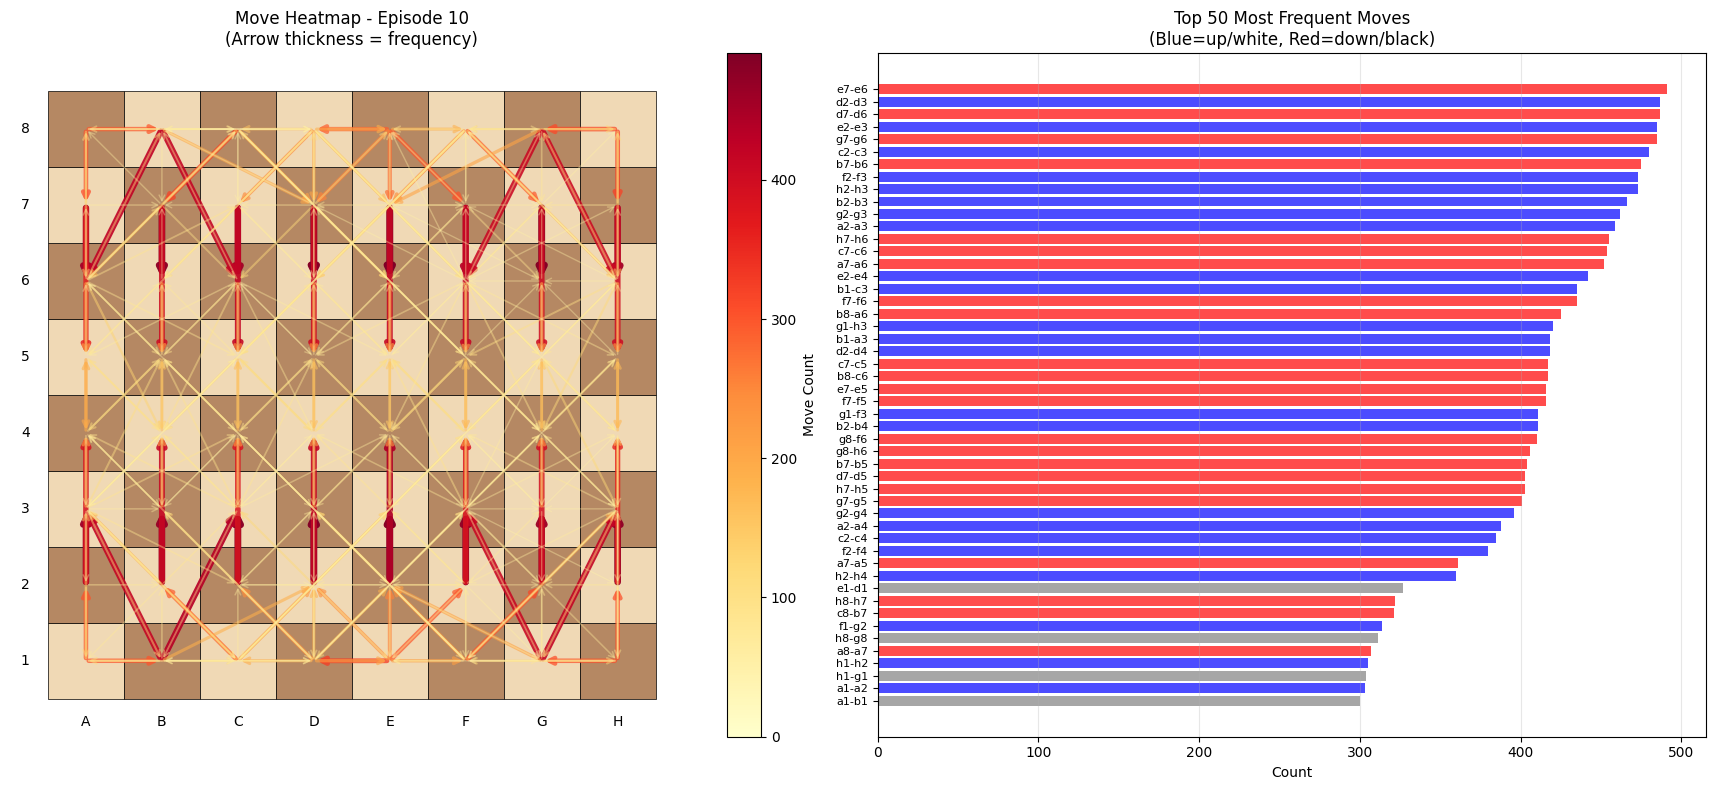


Top 10 Most Frequent Moves:
--------------------------------------------------
 1. e7 -> e6:  491 times (0.6%)
 2. d2 -> d3:  487 times (0.6%)
 3. d7 -> d6:  487 times (0.6%)
 4. e2 -> e3:  485 times (0.6%)
 5. g7 -> g6:  485 times (0.6%)
 6. c2 -> c3:  480 times (0.6%)
 7. b7 -> b6:  475 times (0.6%)
 8. f2 -> f3:  473 times (0.6%)
 9. h2 -> h3:  473 times (0.6%)
10. b2 -> b3:  466 times (0.6%)
Visualizing episode 1810...
Episode 1810 Move Analysis
Total unique moves: 1778
Total move occurrences: 52914
Max single move count: 688


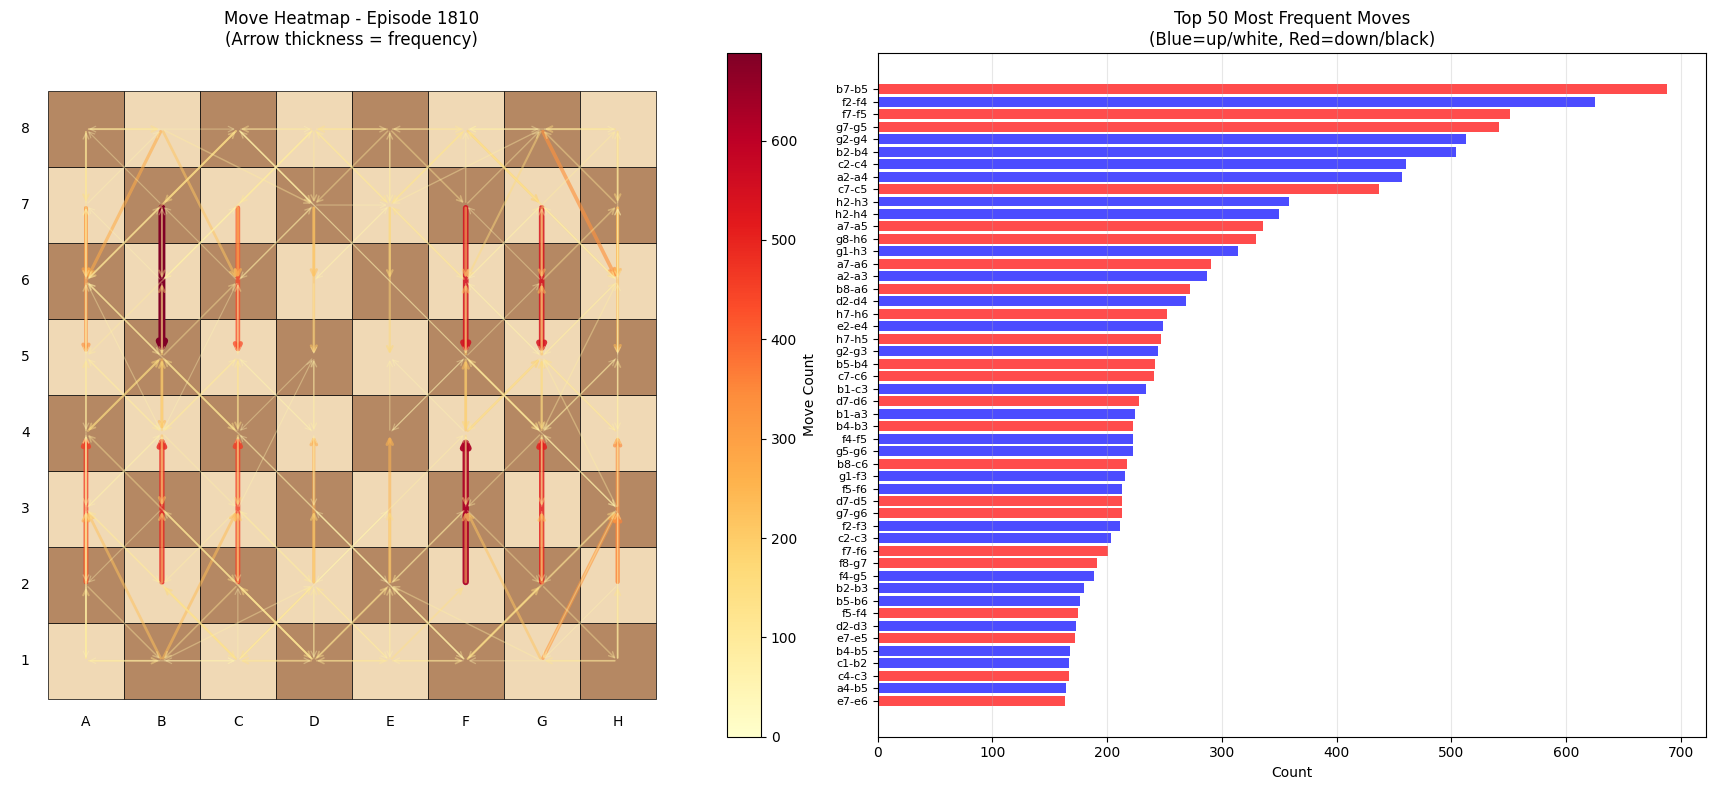


Top 10 Most Frequent Moves:
--------------------------------------------------
 1. b7 -> b5:  688 times (1.3%)
 2. f2 -> f4:  625 times (1.2%)
 3. f7 -> f5:  551 times (1.0%)
 4. g7 -> g5:  542 times (1.0%)
 5. g2 -> g4:  513 times (1.0%)
 6. b2 -> b4:  504 times (1.0%)
 7. c2 -> c4:  461 times (0.9%)
 8. a2 -> a4:  457 times (0.9%)
 9. c7 -> c5:  437 times (0.8%)
10. h2 -> h3:  359 times (0.7%)


In [762]:
# Find the latest episode
episode_files = [f for f in os.listdir(LOG_DIR) if f.startswith("episode_") and f.endswith(".json")]
if episode_files:
    # Extract episode numbers and find the latest
    first_episode = min([int(f.split('_')[1]) for f in episode_files])
    print(f"Visualizing first episode {first_episode}...")
    visualize_move_tracking(first_episode,move_cutoff=50)
    latest_episode = max([int(f.split('_')[1]) for f in episode_files])
    print(f"Visualizing episode {latest_episode}...")
    visualize_move_tracking(latest_episode,move_cutoff=50)
else:
    print("No episode files found")